In [13]:
%matplotlib inline
%reload_ext Cython
from __future__ import print_function
import time
import pylab
import numpy as np
from numpy import int16, uint16, uint8, float16, log2

import cv2
from cv2 import cvtColor as convertColor, COLOR_BGR2GRAY, COLOR_GRAY2RGB,\
                resize, imread, imwrite

try:                  #nearest neighboor interpolation
  from cv2.cv import CV_INTER_NN, \
                     CV_CAP_PROP_FRAME_WIDTH, \
                     CV_CAP_PROP_FRAME_HEIGHT, \
                     CV_CAP_PROP_FPS, \
                     CV_LOAD_IMAGE_GRAYSCALE
except:
  from cv2 import INTER_NEAREST as CV_INTER_NN, \
                  CAP_PROP_FRAME_WIDTH as CV_CAP_PROP_FRAME_WIDTH, \
                  CAP_PROP_FRAME_HEIGHT as CV_CAP_PROP_FRAME_HEIGHT, \
                  CAP_PROP_FPS as CV_CAP_PROP_FPS, \
                  IMREAD_GRAYSCALE as CV_LOAD_IMAGE_GRAYSCALE

import inspect
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import pyximport; pyximport.install()
#from pydvs.generate_spikes import *
from pydvs.generate_spikes import *

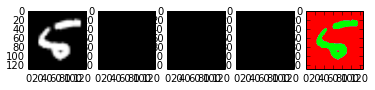

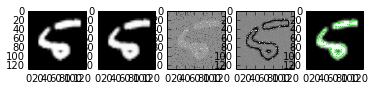

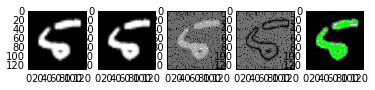

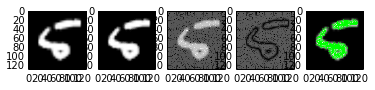

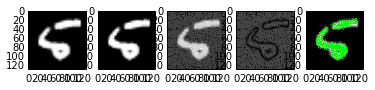

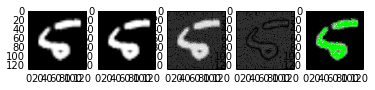

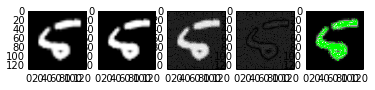

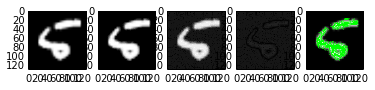

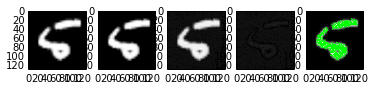

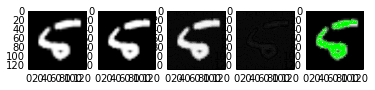

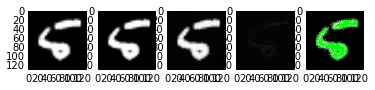

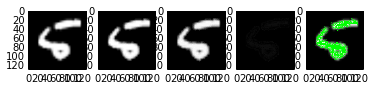

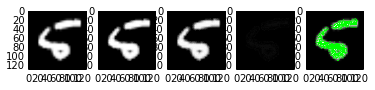

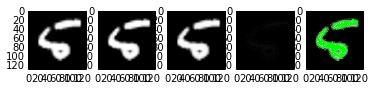

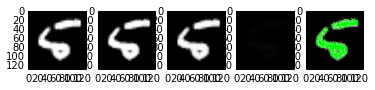

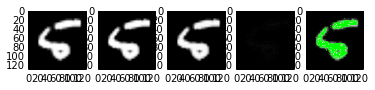

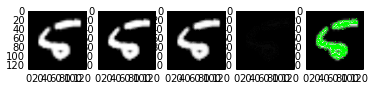

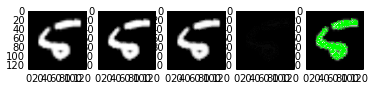

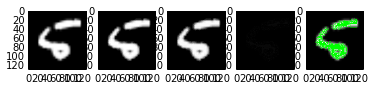

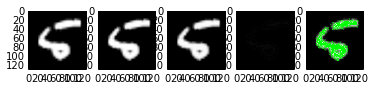

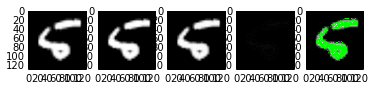

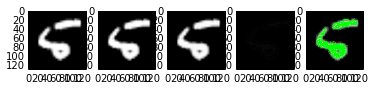

In [21]:
img_path = "../mnist/t10k-images-idx3-ubyte__idx_008__lbl_5_.png"

UP_POLARITY    = 0
DOWN_POLARITY  = 1
MERGED_POLARITY = 2
RECTIFIED_POLARITY = 3

orig_w = 28
cam_w = 128
num_cycles = 100
history_weight = 0.95
cam_fps = 30
frame_time_ms = int(1000./cam_fps)
data_shift = uint8(np.log2(cam_w))
flag_shift = uint8(2*data_shift)
data_mask  = uint8(cam_w - 1)
noise_probability = 10 # per-cent

orig_img = np.zeros((orig_w, orig_w), dtype=int16)
padd_img = np.zeros((cam_w, cam_w), dtype=int16)
send_ref = 128*np.ones((cam_w, cam_w), dtype=int16)
recv_ref = 128*np.ones((cam_w, cam_w), dtype=int16)
curr = np.zeros((cam_w, cam_w), dtype=int16)
diff = np.zeros((cam_w, cam_w), dtype=int16)
abs_diff = np.zeros((cam_w, cam_w), dtype=int16)
spikes = np.zeros((cam_w, cam_w), dtype=int16)
spk_img = np.zeros((cam_w, cam_w, 3), dtype=uint8)
thresh = int( (2**8 - 1)*0.06 )
frm = (cam_w - orig_w)/2.
to  = frm + orig_w
show_every_n_cycle = 5
snd_rcv_diff =  np.zeros((cam_w, cam_w), dtype=int16)

orig_img[:] = imread(img_path, CV_LOAD_IMAGE_GRAYSCALE)
curr[:] = resize(orig_img, (cam_w, cam_w))
base_name = "weight_decay_test___cycle_%03d___%s.png"
for i in range(num_cycles):
    if (i+1)%show_every_n_cycle == 0 or \
       i == 0 or i == 1:
        pylab.figure()
        pylab.axis("off")
        pylab.subplot(1, 5, 1)
        pylab.imshow(curr, cmap='Greys_r')
        imwrite(base_name%(i+1, "src"), curr)
                
        pylab.subplot(1, 5, 2)
        pylab.imshow(send_ref, cmap='Greys_r')
        imwrite(base_name%(i+1, "send"), send_ref)
        
        pylab.subplot(1, 5, 3)
        pylab.imshow(recv_ref, cmap='Greys_r')
        imwrite(base_name%(i+1, "recv"), recv_ref)
        pylab.subplot(1, 5, 4)
        #pylab.imshow(np.abs(curr-recv_ref), cmap='Greys_r')
        snd_rcv_diff[:] = np.abs(send_ref-recv_ref).astype(int16)
        pylab.imshow(snd_rcv_diff, cmap='Greys_r', vmin=0, vmax=255)
        imwrite(base_name%(i+1, "send-recv_diff"), snd_rcv_diff)
    
    diff[:], abs_diff[:], spikes[:] = thresholded_difference(curr, send_ref, thresh)
    send_ref[:] = update_reference_time_thresh(abs_diff, spikes, send_ref,
                                               thresh,
                                               frame_time_ms,
                                               history_weight)
    if i == 0:
        recv_ref[:] = update_reference_time_thresh_noise(abs_diff, spikes, recv_ref,
                                                         cam_w, cam_w,
                                                         thresh,
                                                         frame_time_ms,
                                                         history_weight,
                                                         noise_probability)
    else:
        recv_ref[:] = update_reference_time_thresh(abs_diff, spikes, recv_ref,
                                                   thresh,
                                                   frame_time_ms,
                                                   history_weight)
        
    spk_img[:] = render_frame(spikes, curr, cam_w, cam_w, MERGED_POLARITY)
    if (i+1)%show_every_n_cycle == 0 or \
       i == 0 or i == 1:
        pylab.subplot(1, 5, 5)
        pylab.imshow(convertColor(spk_img, cv2.COLOR_BGR2RGB))
        imwrite(base_name%(i+1, "spikes"), spk_img)
        pylab.show()